# Graph embedding using [DeepWalk](https://arxiv.org/pdf/1403.6652.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA

from graph_embedding_continuity import *

In [2]:
N = 20

N_TRAIN = 100
EMBEDDING_SIZE = 4
WALK_LENGTH = 10
WINDOW_SIZE = 2
N_NEG = 2
HIDDEN_SIZE = 16

USE_CUDA = False
USE_PCA_TO_PLOT = True

## Embedding under closing of a loop.

Closing the loop greatly change the diffusion of the random walk. Empirically, this generates significantly different embeddings for the chain and the cycle.

Epoch : 1/100: 100%|██████████████████████████████████| 20.0/20.0 [00:00<00:00, 38.2it/s, loss=51.4]
Epoch : 10/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 35.5it/s, loss=50.8]
Epoch : 20/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 35.3it/s, loss=44.5]
Epoch : 30/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 36.7it/s, loss=38.6]
Epoch : 40/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 38.0it/s, loss=36.7]
Epoch : 50/100: 100%|███████████████████████████████████| 20.0/20.0 [00:00<00:00, 34.5it/s, loss=36]
Epoch : 60/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 41.0it/s, loss=34.3]
Epoch : 70/100: 100%|███████████████████████████████████| 20.0/20.0 [00:00<00:00, 39.6it/s, loss=36]
Epoch : 80/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 33.0it/s, loss=35.1]
Epoch : 90/100: 100%|█████████████████████████████████| 20.0/20.0 [00:00<00:00, 39.3it/s, l

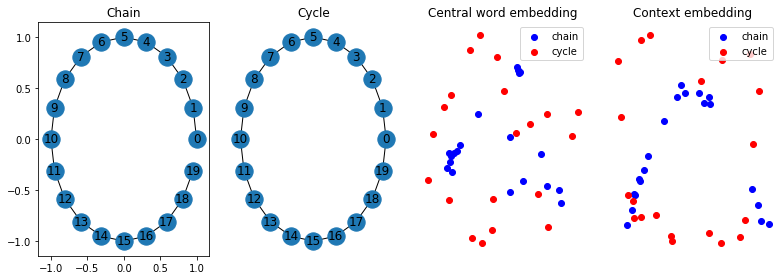

In [3]:
chain = generate_chain(N)
cycle = generate_cycle(N)

# add some random weights on each edge,
# same weight for the edges common to
# the chain and the cycle.
shared_weights = np.random.rand(N-1)

for v, _ in chain.edges():
    chain[v][v+1]['weight'] = shared_weights[v]
    cycle[v][v+1]['weight'] = shared_weights[v]

# put a tiny weight on the closing edge of the cycle.
cycle[N-1][0]['weight'] = 0.1*np.random.rand()

# save layout
pos = nx.shell_layout(cycle)
    
emb_chain_word, emb_chain_context = deepwalk_embedding(chain,
                                                       k=EMBEDDING_SIZE,
                                                       n_train=N_TRAIN,
                                                       walk_length=WALK_LENGTH,
                                                       window_size=WINDOW_SIZE,
                                                       n_neg=N_NEG,
                                                       hidden_size = HIDDEN_SIZE,
                                                       use_cuda=USE_CUDA,
                                                      )

emb_cycle_word, emb_cycle_context = deepwalk_embedding(cycle,
                                                       k=EMBEDDING_SIZE,
                                                       n_train=N_TRAIN,
                                                       walk_length=WALK_LENGTH,
                                                       window_size=WINDOW_SIZE,
                                                       n_neg=N_NEG,
                                                       hidden_size = HIDDEN_SIZE,
                                                       use_cuda=USE_CUDA,
                                                      )

if USE_PCA_TO_PLOT:
    # extract 2 principal components to plot
    pca = PCA(n_components=2)
    emb_chain_word = pca.fit_transform(emb_chain_word.cpu())
    emb_chain_context = pca.fit_transform(emb_chain_context.cpu())
    emb_cycle_word = pca.fit_transform(emb_cycle_word.cpu())
    emb_cycle_context = pca.fit_transform(emb_cycle_context.cpu())

# plot the graph
fig, axes = plt.subplots(figsize=(11,4), nrows=1, ncols=4)

ax = axes[0]
nx.draw_networkx(chain, pos = pos, ax=ax)
ax.set_title('Chain')
    
ax = axes[1]
nx.draw_networkx(cycle, pos = pos, ax=ax)
ax.set_title('Cycle')
ax.axis('off')

ax = axes[2]
ax.scatter(emb_chain_word[:, 0], emb_chain_word[:, 1], label='chain', color='b')
ax.scatter(emb_cycle_word[:, 0], emb_cycle_word[:, 1], label='cycle', color='r')
ax.set_title('Central word embedding')
ax.legend(loc='upper right')
ax.axis('off')

ax = axes[3]
ax.scatter(emb_chain_context[:, 0], emb_chain_context[:, 1], label='chain', color='b')
ax.scatter(emb_cycle_context[:, 0], emb_cycle_context[:, 1], label='cycle', color='r')
ax.set_title('Context embedding')
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()